# Analysis of the dataset

In [2]:
from rasterio.plot import show
import rasterio
import numpy as np
import PIL.Image as Image
import cv2 


In [3]:
# Fonction pour lire les fichiers raster avec rasterio
def read_rasterio(file_path):
    with rasterio.open(file_path) as src:
        return src.read()
    
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    out = np.zeros_like(im)
    # faire l'equalization par channel
    def equalize(im_channel):
        v_min, v_max = np.percentile(im_channel,percentiles),np.percentile(im_channel, 100 - percentiles)

        # Clip the image to the percentile values
        im_clipped = np.clip(im_channel, v_min, v_max)

        # Scale the image to the 0-255 range
        im_scaled = np.round((im_clipped - v_min)*255 / (v_max - v_min))
        return im_scaled.astype(np.uint8)
    
    for channel in range(im.shape[2]):
        out[:,:,channel] = equalize(im[:,:,channel])
    
    return out

In [4]:
def preprocess_s2(img_array, size = (1000, 1000), percentiles=10):
    rgb_channel = img_array[0:3, :,:]
    rgb_channel = np.moveaxis(rgb_channel, 0, -1)
    rgb_channel = cv2.resize(rgb_channel, size)
    scaled_image = simple_equalization_8bit(rgb_channel, percentiles)
    return scaled_image

def preprocess_s1(img_array, size = (1000, 1000), percentiles=10):
    channel_1 = img_array[0,:,:]
    channel_1 = channel_1[np.newaxis, :, : ]
    channel_1 = np.moveaxis(channel_1, 0, -1)
    channel_1 = cv2.resize(channel_1, size)
    return channel_1    

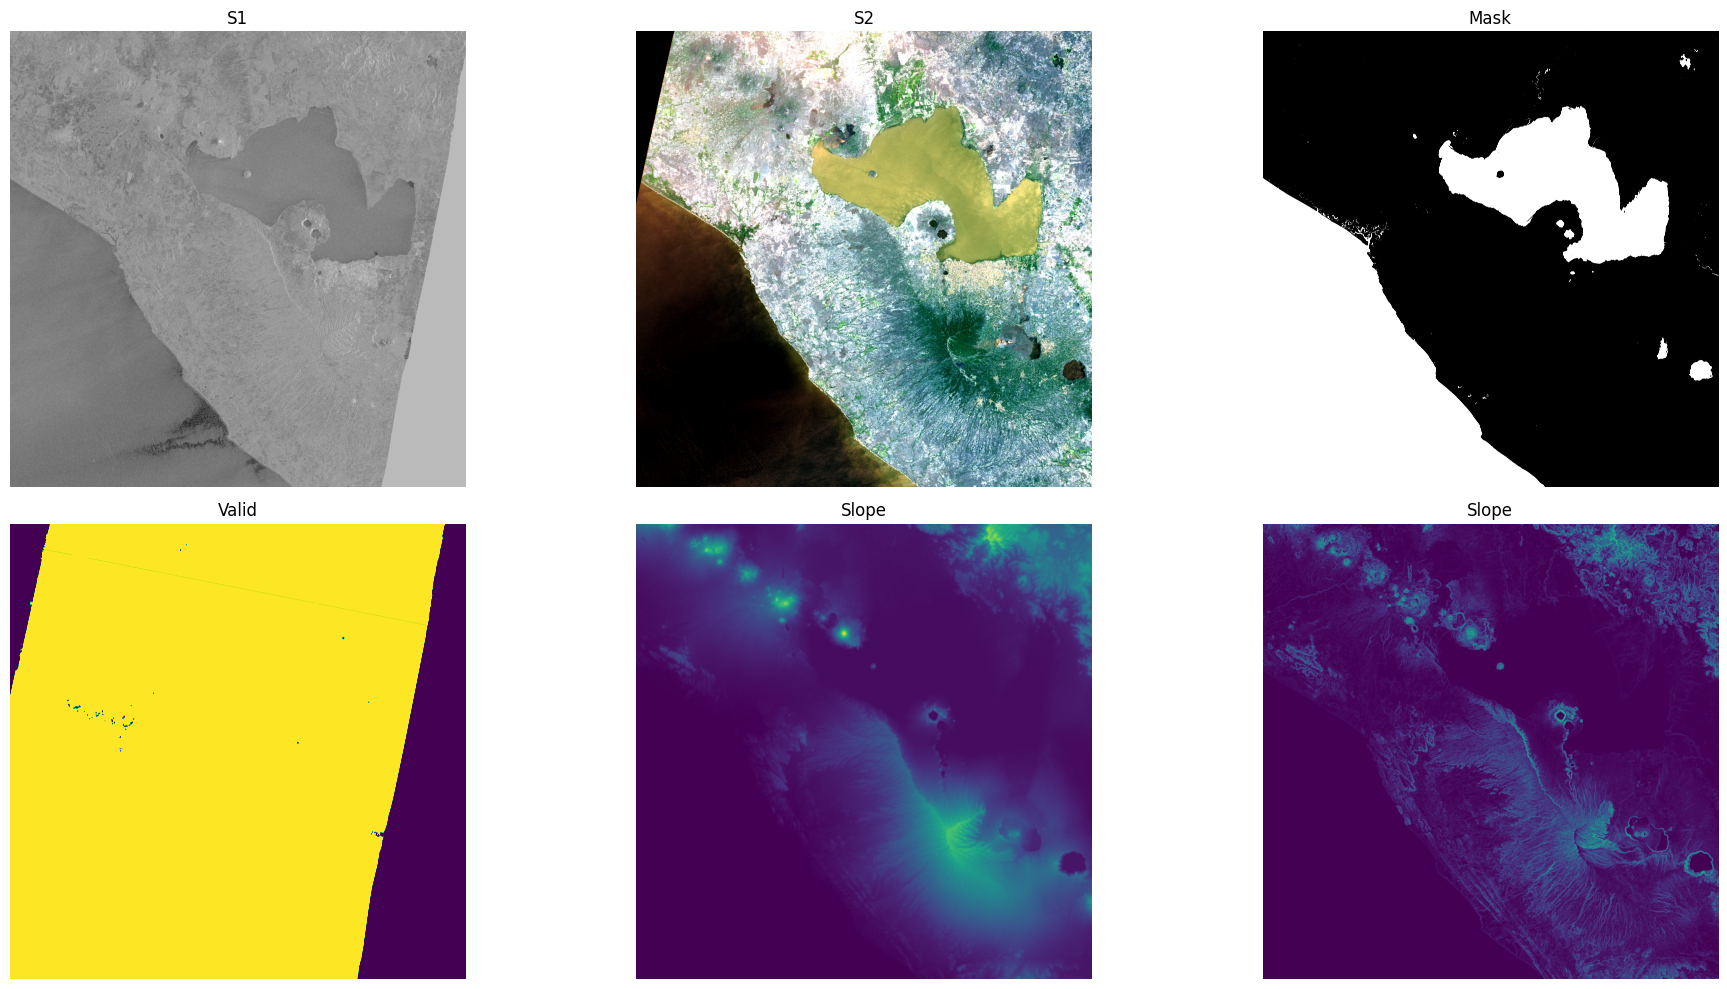

In [17]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np


def create_plot(sat_dir):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))  # 2 lignes, 4 colonnes
    
    # Prépare les chemins vers les images en filtrant la liste des fichiers
    sort_list = os.listdir(sat_dir)
    s1_list = sorted([x for x in sort_list if "s1" in x and 'img' in x])
    s2_list = sorted([x for x in sort_list if "s2" in x and 'img' in x])
    mask_list = sorted([x for x in sort_list if "msk" in x])
    valid_list = sorted([x for x in sort_list if "valid" in x])
    elevation_list = sorted([x for x in sort_list if "elevation" in x])
    slope_list = sorted([x for x in sort_list if "slope" in x])

    # Affiche les images Sentinel-1 et Sentinel-2
    for i, img_path in enumerate(s1_list + s2_list):
        title = "S1" if "s1" in img_path else "S2"
        img = read_rasterio(os.path.join(sat_dir, img_path))
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        if 's2' in img_path:
            img = preprocess_s2(img)
        elif 's1' in img_path:
            img = preprocess_s1(img)
        ax[i//3][i%3].imshow(img, cmap='gray')
        ax[i//3][i%3].set_title(title)
        ax[i//3][i%3].axis('off')

    # Affiche les masques et les images de validation
    for i, img_path in enumerate(mask_list):
        title = "Mask"
        img = read_rasterio(os.path.join(sat_dir, img_path))
        img = img.squeeze()  # Assure-toi que la dimension inutile est supprimée
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        cmap = 'gray' if 'msk' in img_path else 'viridis'
        # Calcule la bonne position de subplot
        row = (i + len(s1_list + s2_list)) // 3
        col = (i + len(s1_list + s2_list)) % 3
        ax[row][col].imshow(img, cmap=cmap)
        ax[row][col].set_title(title)
        ax[row][col].axis('off')

    # Place les images d'élévation et de pente dans la 4ème colonne
    for i, img_path in enumerate(elevation_list + slope_list):
        title = "Elevation" if "Elevation" in img_path else "Slope"
        img = read_rasterio(os.path.join(sat_dir, img_path))
        img = img.squeeze()  # Supprime l'axe singleton pour l'affichage
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        row = (i + len(s1_list + s2_list+ mask_list)) // 3
        col = (i + len(s1_list + s2_list + mask_list)) % 3
        ax[row][col].imshow(img, cmap='viridis')
        ax[row][col].set_title(title)
        ax[row][col].axis('off')
    
    ax[1][0].imshow(read_rasterio(os.path.join(sat_dir, valid_list[0])).squeeze(), cmap='viridis')
    ax[1][0].set_title('Valid')
    ax[1][0].axis('off')
    

    plt.tight_layout()
    plt.show()

# Call the function with the directory path
create_plot('part1/8')

PLot every 

In [13]:
import tqdm
import os
import rasterio
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt

In [24]:
def compute_iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def compute_recall(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    gt_area = gt.sum()
    recall = intersection / gt_area if gt_area != 0 else 0
    return recall

def compute_precision(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    pred_area = pred.sum()
    precision = intersection / pred_area if pred_area != 0 else 0
    return precision

def read_rasterio(fp):
    img = rasterio.open(fp)
    return img
    
def read_tif_image(tif_path):
    img = Image.open(tif_path)
    img = np.array(img)
    return img

In [16]:
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    out = np.zeros_like(im)
    # faire l'equalization par channel
    def equalize(im_channel):
        v_min, v_max = np.percentile(im_channel,percentiles),np.percentile(im_channel, 100 - percentiles)

        # Clip the image to the percentile values
        im_clipped = np.clip(im_channel, v_min, v_max)

        # Scale the image to the 0-255 range
        im_scaled = np.round((im_clipped - v_min)*255 / (v_max - v_min))
        return im_scaled.astype(np.uint8)
    
    for channel in range(im.shape[2]):
        out[:,:,channel] = equalize(im[:,:,channel])
    
    return out

  0%|          | 0/12 [00:00<?, ?it/s]

(10980, 10980)


/Users/emmagauillard/Documents/MVA/Remote_sensing/projet/projet_remote/env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


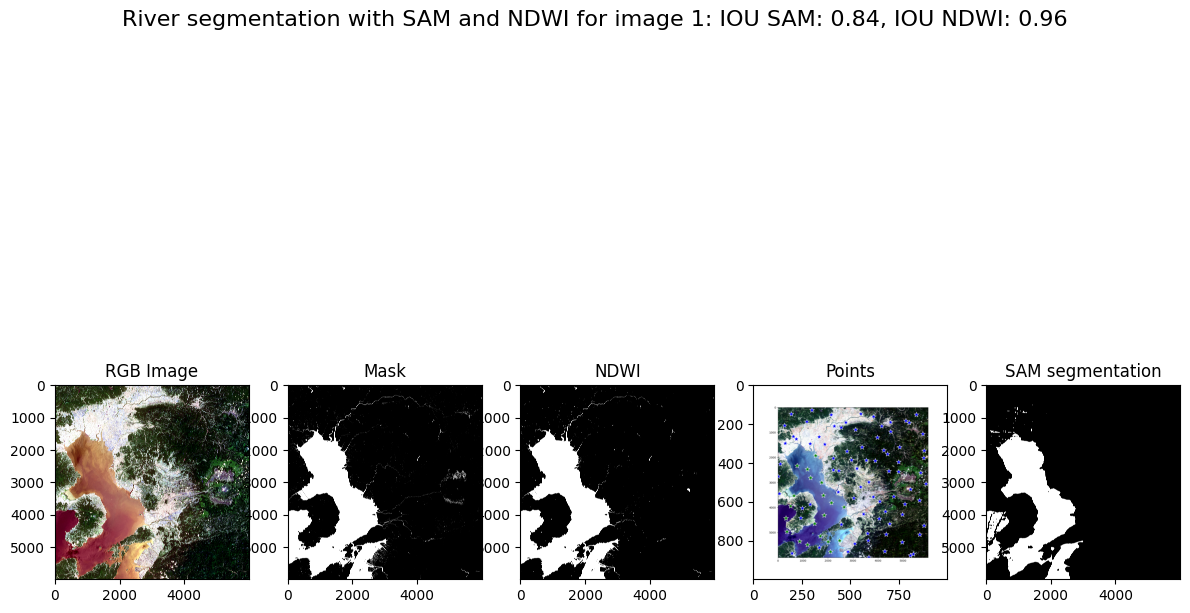

  8%|▊         | 1/12 [00:15<02:51, 15.57s/it]

(10980, 10980)


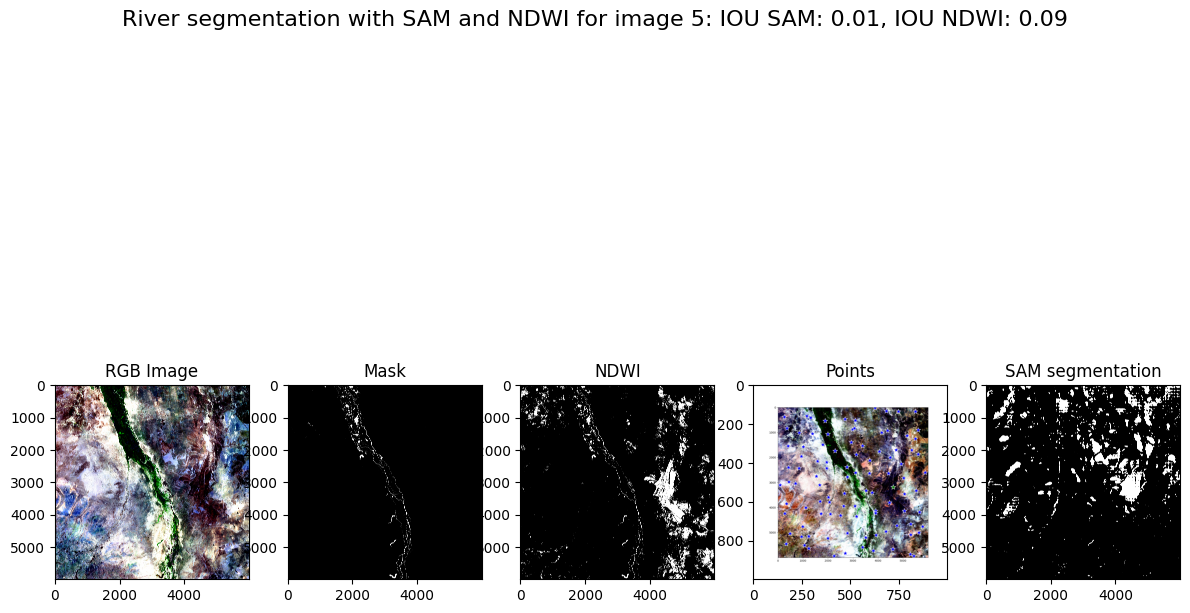

 17%|█▋        | 2/12 [00:30<02:33, 15.35s/it]

(10980, 10980)


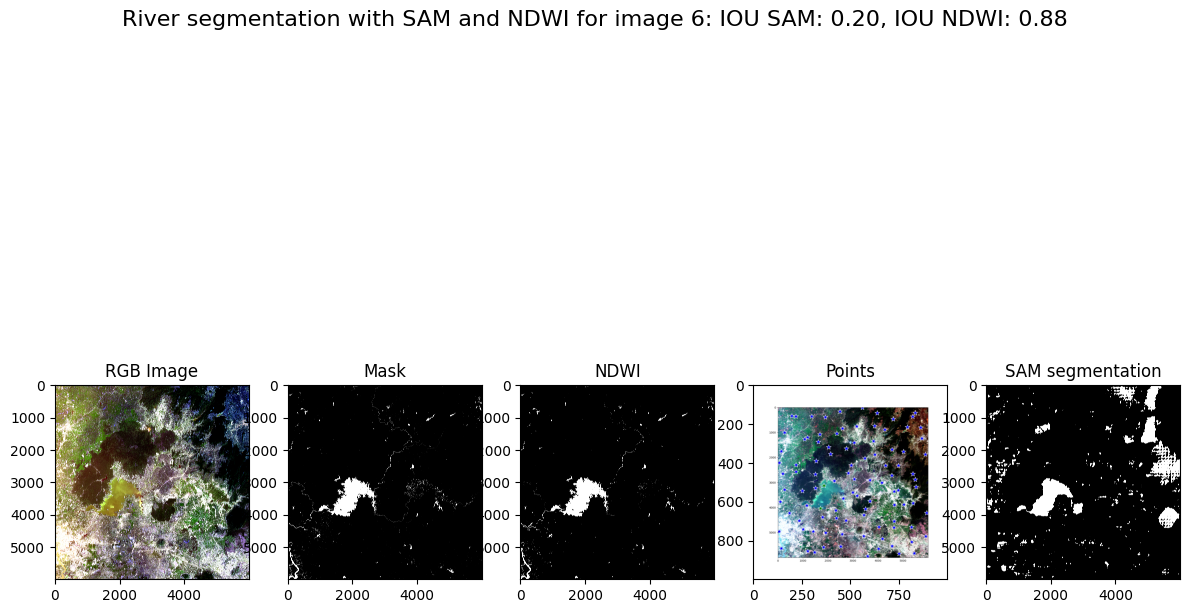

 25%|██▌       | 3/12 [00:46<02:18, 15.36s/it]

(10980, 10980)


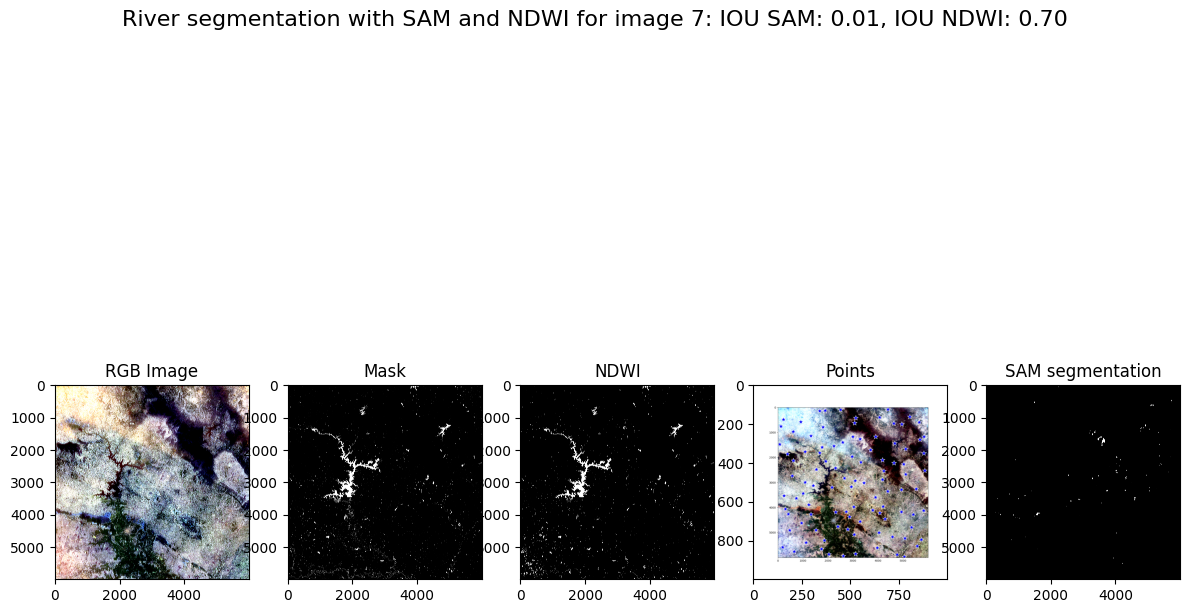

 33%|███▎      | 4/12 [01:01<02:02, 15.28s/it]

(10980, 10980)


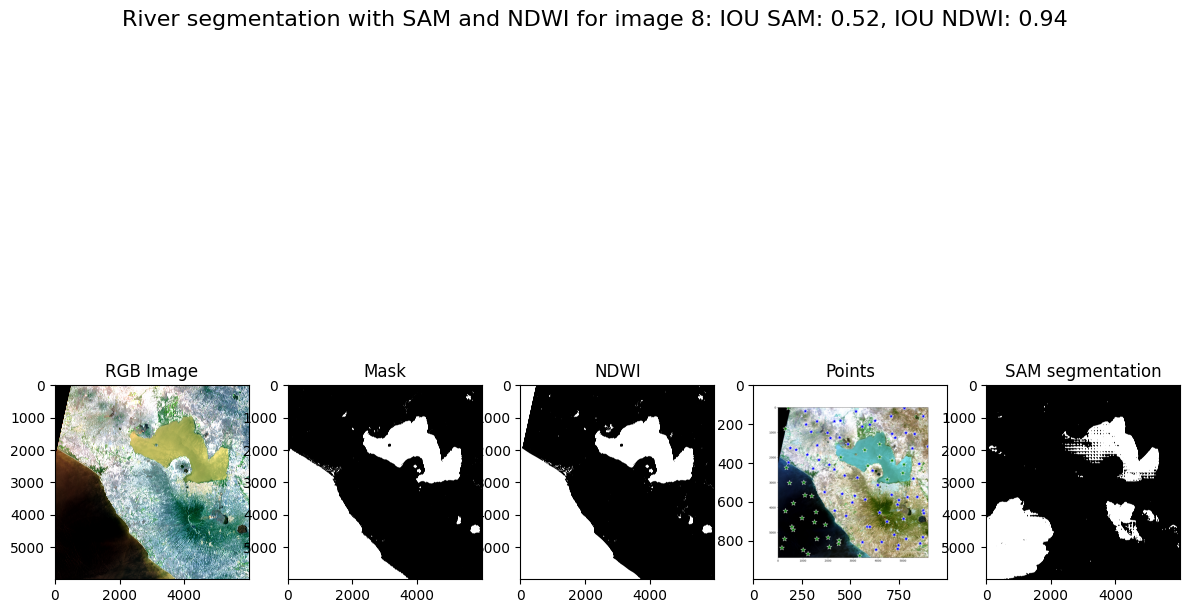

 42%|████▏     | 5/12 [01:16<01:46, 15.16s/it]

(10980, 10980)


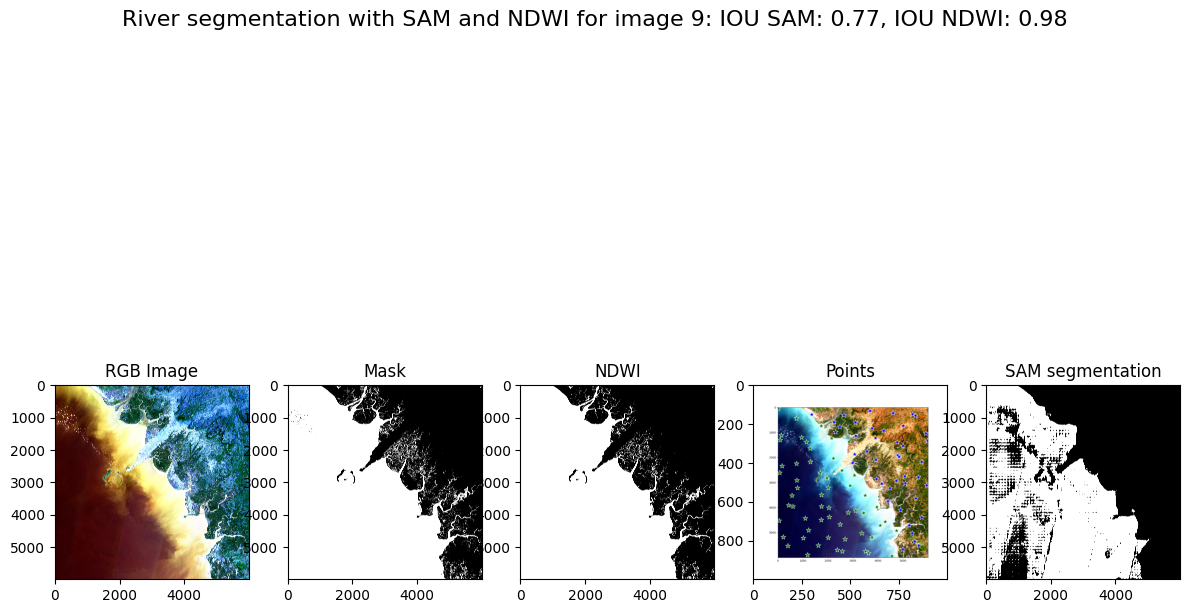

 50%|█████     | 6/12 [01:31<01:30, 15.12s/it]

(10980, 10980)


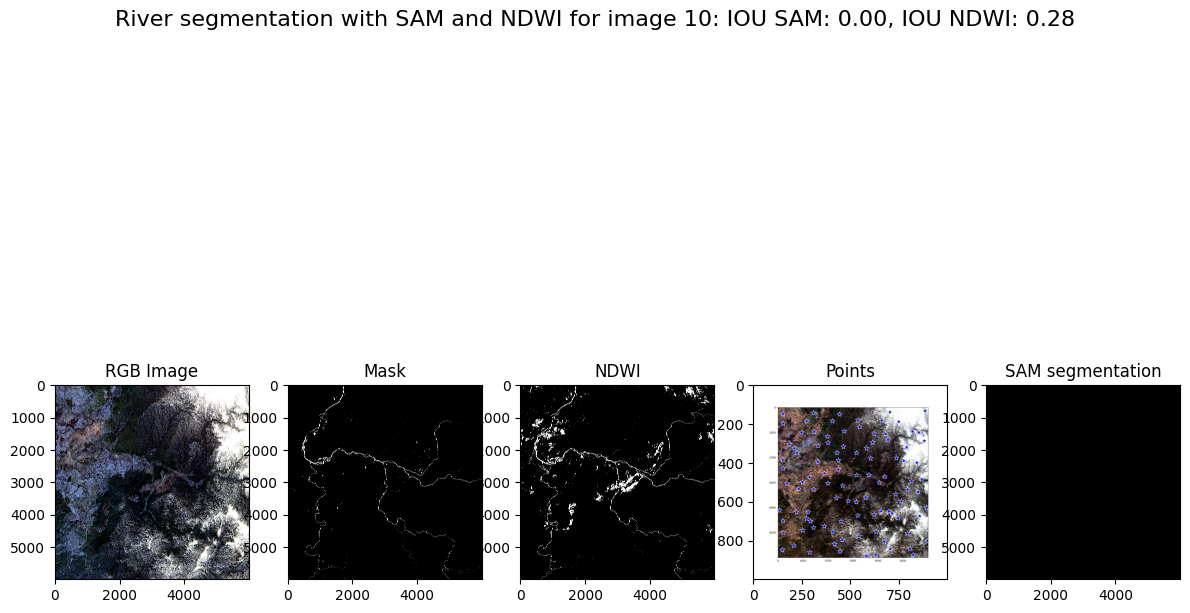

 58%|█████▊    | 7/12 [01:47<01:17, 15.58s/it]

(10980, 10980)


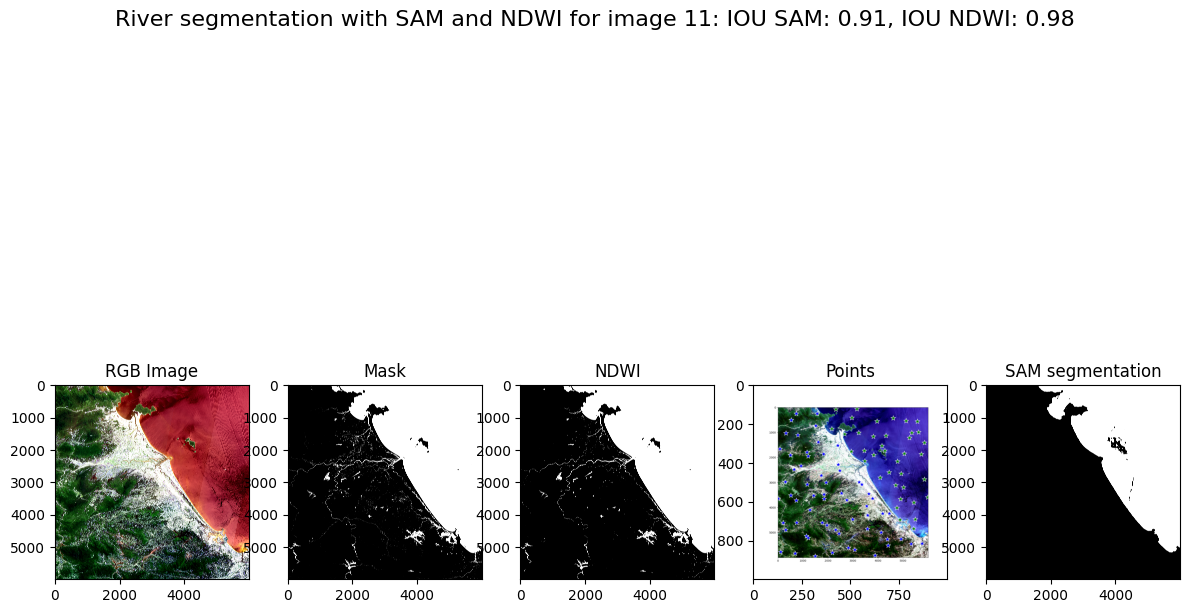

 67%|██████▋   | 8/12 [02:03<01:02, 15.56s/it]

(10980, 10980)


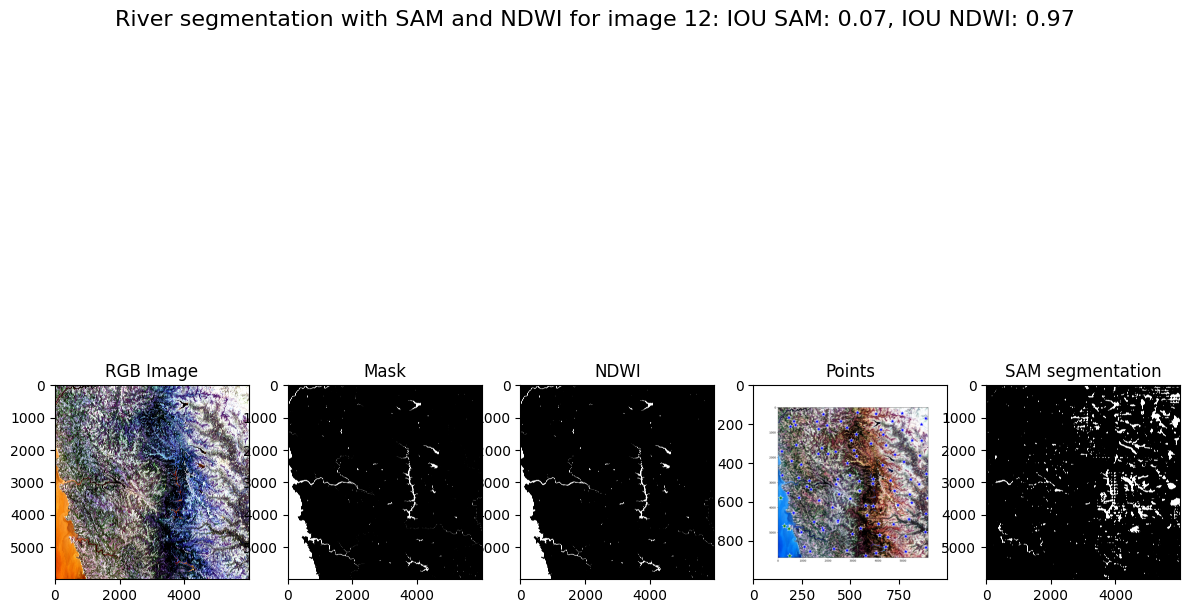

 75%|███████▌  | 9/12 [02:20<00:47, 15.99s/it]

(10980, 10980)


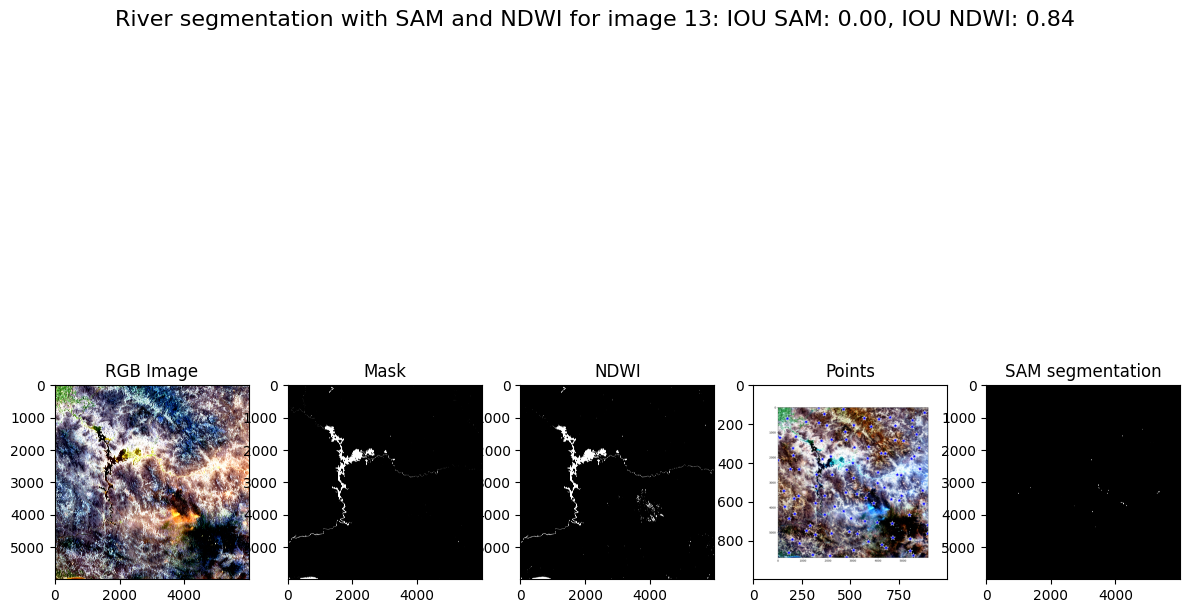

 83%|████████▎ | 10/12 [02:36<00:31, 15.93s/it]

(10980, 10980)


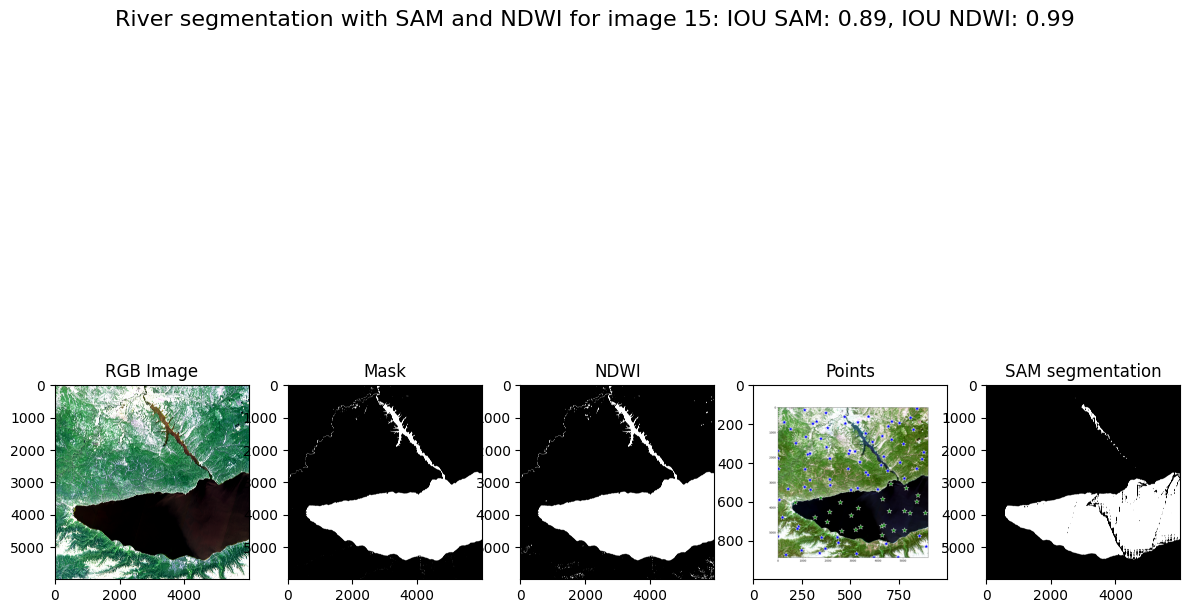

 92%|█████████▏| 11/12 [02:51<00:15, 15.66s/it]

(10980, 10980)


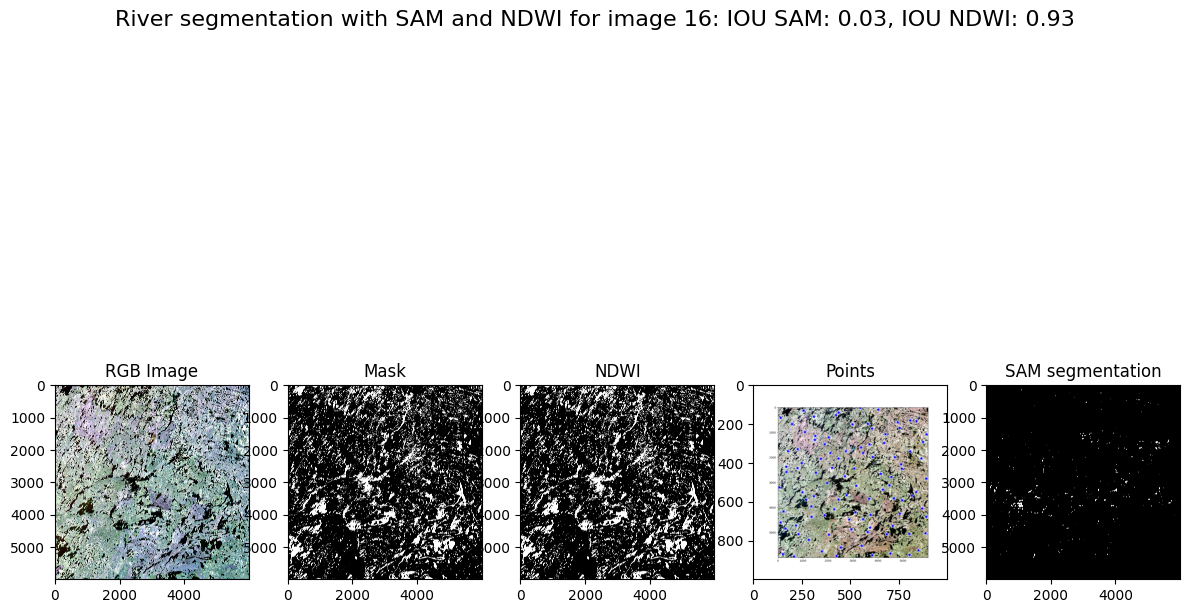

100%|██████████| 12/12 [03:06<00:00, 15.57s/it]


In [25]:
list = [1,5,6,7,8,9,10,11,12,13,15,16]
path_masks = "masks"
iou = {}
precision = {}
recall = {}

for n_image in tqdm.tqdm(list):
    checkpoint_path = 'checkpoint/sam_vit_h_4b8939.pth'
    sat_dir = 'part1/' + str(n_image) 
    path_image = 'sentinel12_s2_' + str(n_image) +'_img.tif'
    path_mask = 'sentinel12_s2_' + str(n_image) +'_msk.tif'
    # read image
    img = read_rasterio(os.path.join(sat_dir, path_image))
    img_array = img.read()
    img_array = np.moveaxis(img_array, 0, -1)
    resized = cv2.resize(img_array, (6000, 6000))
    rgb_channel = resized[:,:,0:3]
    rgb_channel =  simple_equalization_8bit(rgb_channel, percentiles=10)
    
    # read mask
    gt = read_rasterio(os.path.join(sat_dir, path_mask))
    gt_array = gt.read()[0]
    print(gt_array.shape)
    gt_resized = cv2.resize(gt_array, (6000, 6000))
    
    # read ndwi and mask
    ndwi = read_rasterio(os.path.join(path_masks,'ndwi_'+str(n_image)+'.tif'))
    ndwi = ndwi.read().squeeze()
    mask_SAM = read_rasterio(os.path.join(path_masks,'mask2_'+str(n_image)+'.tif')).read().squeeze()
    # read png points
    points = cv2.imread(os.path.join(path_masks,'points_'+str(n_image)+'.png'))
    
    # compute IOU between mask and gt
    iou_SAM = compute_iou(mask_SAM, gt_resized)
    iou_ndwi = compute_iou(ndwi, gt_resized)
    precision_SAM = compute_precision(mask_SAM, gt_resized)
    recall_SAM = compute_recall(mask_SAM, gt_resized)
    precision_ndwi = compute_precision(ndwi, gt_resized)
    recall_ndwi = compute_recall(ndwi, gt_resized)
    
    iou[n_image] = [iou_SAM, iou_ndwi]
    precision[n_image] = [precision_SAM, precision_ndwi]
    recall[n_image] = [recall_SAM, recall_ndwi]

    
    
    
    
    # save mask rajouter une dim 1
    fig, ax = plt.subplots(1, 5, figsize=(12, 10))
    # mettre un titre sur la figure 
    titre = 'River segmentation with SAM and NDWI for image {}: IOU SAM: {:.2f}, IOU NDWI: {:.2f}'.format(n_image, iou_SAM, iou_ndwi)
    fig.suptitle(titre, fontsize=16, y=0.92)

    ax[0].imshow(rgb_channel)
    ax[0].set_title('RGB Image')
    ax[1].imshow(gt_resized, cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(ndwi, cmap='gray')
    ax[2].set_title('NDWI')
    ax[3].imshow(points)
    ax[3].set_title('Points')
    ax[4].imshow(mask_SAM, cmap='gray')
    ax[4].set_title('SAM segmentation')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Tu peux expérimenter avec ces valeurs
    fig.subplots_adjust(top=0.85, wspace=0.2)   
    plt.show()

    
    
    
    
    

In [27]:
# mean IOU for SAM
iou_SAM = [iou[i][0] for i in iou.keys()]
mean_iou_SAM = np.mean(iou_SAM)
print('Mean IOU for SAM:', mean_iou_SAM)

iou_ndwi = [iou[i][1] for i in iou.keys()]
mean_iou_ndwi = np.mean(iou_ndwi)
print('Mean IOU for NDWI:', mean_iou_ndwi)

precision_SAM = [precision[i][0] for i in precision.keys()]
mean_precision_SAM = np.mean(precision_SAM)
print('Mean precision for SAM:', mean_precision_SAM)

precision_ndwi = [precision[i][1] for i in precision.keys()]
mean_precision_ndwi = np.mean(precision_ndwi)
print('Mean precision for NDWI:', mean_precision_ndwi)

recall_ndwi = [recall[i][1] for i in recall.keys()]
mean_recall_ndwi = np.mean(recall_ndwi)
print('Mean recall for NDWI:', mean_recall_ndwi)

recall_SAM = [recall[i][0] for i in recall.keys()]
mean_recall_SAM = np.mean(recall_SAM)
print('Mean recall for SAM:', mean_recall_SAM)

Mean IOU for SAM: 0.35288087445222344
Mean IOU for NDWI: 0.7958243435443872
Mean precision for SAM: 0.5289284616384381
Mean precision for NDWI: 0.8253002620610866
Mean recall for NDWI: 0.9482585432261635
Mean recall for SAM: 0.40273207029454744
